# Projeto de otimização de portfólio
##### *Autor*: Victor Flávio P. Dornelos

## 1 Análise exploratória dos dados

In [54]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import yfinance as yf
import pickle
from help import alocacao_ativos, visualiza_carteira,alocacao_markowitz

In [55]:
# Lista com as ações da carteira
acoes = ['TAEE11.SA','BBAS3.SA','ABEV3.SA','WEGE3.SA','RANI3.SA','GOGL34.SA','BERK34.SA']

In [56]:
# Criando DF com as cotações usando Adj Close pelo yfinance
df = pd.DataFrame()
for i in acoes:
    df[i] = yf.download(i, start='2021-01-01')['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [57]:
# Salvando DF para evitar possíveis com yfinance
df.to_csv('carteira.csv')
#df=pd.read_csv('carteira.csv',index_col='Date')

In [58]:
# Descrição estatística dos dados
df.describe()

,TAEE11.SA,BBAS3.SA,ABEV3.SA,WEGE3.SA,RANI3.SA,GOGL34.SA,BERK34.SA
count,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000
mean,31.626524,18.246046,13.520553,34.422752,7.095992,53.073726,81.337269
std,3.194593,5.448385,0.946959,4.205932,1.941754,8.912342,9.680268
min,21.692646,11.193897,11.520000,22.032598,3.993166,35.822094,59.950001
25%,29.438837,13.516212,12.857918,32.057381,5.521672,46.702682,74.842497
50%,32.228571,16.189788,13.493954,34.935814,6.871072,52.069439,80.119999
75%,34.095095,22.951791,14.006313,37.730060,8.648023,58.549703,85.727503
max,36.577717,29.474905,17.029501,43.637676,12.309293,77.540001,109.150002


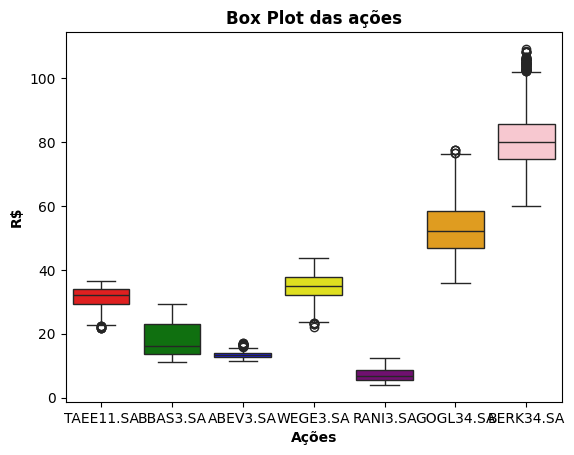

In [59]:
# Criando Box Plot para os papéis
cores= ["Red", "Green", "Blue", "Yellow", "Purple", "Orange", "Pink", "Brown", "Black", "White", "Gray", "Cyan", "Magenta"]
sns.boxplot(data=df,palette=cores)
plt.title('Box Plot das ações',fontweight='bold')
plt.xlabel('Ações',fontweight='bold')
plt.ylabel('R$',fontweight='bold')
plt.grid(False)
plt.show()

Durante o intervalo de tempo de 2021 até maio de 2024, o gráfico Box Plot e a descrição do df, destacam que a Petrobras e a Vale  tiveram as maiores variações de cotações. Enquanto, os demais tiveram variação mais estáveis e próxima entre si, apesar da Embraer ter tido vários Outliers devido sua alta recente dos preços.  

In [60]:
# Criando gráfico das cotações
figura = px.line(title = 'Histórico de cotações das ações')

for i, coluna in enumerate(df.columns):
    figura.add_scatter(x=df.index, y=df[coluna], name=coluna, line=dict(color=cores[i]))


figura.update_layout(
    xaxis_title='Data',
    yaxis_title='R$',
    title_x=0.5
)

figura.show()

O gráfico demonstra que a Vale ficou "lateralizada" e volátil e as demais é visto uma tendência de crescimento de valor de mercado

In [61]:
# Normalizando as cotações para melhor comparação dos retornos
df_normalizado = df.copy()
for i in df_normalizado.columns[0:]:
  df_normalizado[i] = df_normalizado[i] / df_normalizado[i][0];

In [62]:
# Criando gráfico das cotações normalizadas
figura = px.line(title = 'Histórico de cotações das ações (normalizado)')

for i, coluna in enumerate(df.columns):
    figura.add_scatter(x=df_normalizado.index, y=df_normalizado[coluna], name=coluna, line=dict(color=cores[i]))


figura.update_layout(
    xaxis_title='Data',
    yaxis_title='R$',
    title_x=0.5
)

figura.show()

Após a normalização, fica evidente que a maior valorização dos papéis é da Embraer seguida por Petrobras e Banco do Brasil, enquanto, a Vale teve uma pequena queda.

## 2 Otimização de portfólio

### 2.1 Preparação

In [63]:
# Biblioteca necessária
#pip install https://github.com/gkhayes/mlrose/archive/refs/heads/master.zip

In [64]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose

In [65]:
# Biblioteca para buscar valores de CDI
#pip install python-bcb

from bcb import sgs

In [66]:
#taxa_cdi = sgs.get({'cdi':4389},start='2021-01-01')
#media_cdi = float(taxa_cdi.mean() / 100)
media_cdi = 0.10140104772991852 # Salvando valor devido instabilidade do BCB

In [67]:
# Pegando DF limpo
teste = pd.read_csv('carteira.csv')

### 2.2 Método  Markowitz

In [68]:
# Rodando a função
import warnings
warnings.filterwarnings("ignore")
melhor_sharpe_ratio, pesos_markoitz, lista_retorno_esperado, lista_volatilidade_esperada, lista_sharpe_ratio, melhor_volatilidade, melhor_retorno = alocacao_markowitz(teste, 100000, media_cdi, 100000);

In [69]:
# Criando uma carteira com os pesos encontrados
df_M,_,_,_=alocacao_ativos(teste,capital=100000,melhores_pesos=pesos_markoitz)
df_M

,TAEE11.SA,BBAS3.SA,ABEV3.SA,WEGE3.SA,RANI3.SA,GOGL34.SA,BERK34.SA,Capital,tx retorno
0,12674.062303,18519.923139,313.304849,146.822367,17713.154538,19863.574501,30769.158303,100000.000000,0.000000
1,12697.105321,18327.772527,319.983855,155.833963,17515.978888,19896.057369,30479.363017,99392.094940,-0.607905
2,12720.148339,18746.554711,326.460430,159.965972,17417.390023,19844.083986,31218.848936,100433.452398,1.047727
3,12347.609112,19490.505172,324.841259,166.577117,18896.229234,20854.316862,32157.125710,104237.204465,3.787336
4,12616.452192,19603.823333,334.556178,176.651200,19553.486253,21110.935687,32136.788722,105532.693564,1.242828
...,...,...,...,...,...,...,...,...,...
849,18391.774486,33802.784669,270.331888,155.248620,37380.619639,39182.724146,55035.713171,184219.196619,0.119274
850,18488.686811,33902.387624,273.608624,157.161160,36595.498573,39686.866356,54964.535654,184068.744801,-0.081670
851,18278.710791,33977.091622,270.799983,156.080164,36377.407770,40284.562242,55147.564664,184492.217236,0.230062
852,18305.630425,34425.303733,276.651323,157.202746,36944.442193,40258.573566,54928.946895,185296.750880,0.436080


In [70]:
# Devido esse código demorar muito, torna interessante salvar os resultados
dados_M = {
    "melhor_sharpe_ratio": melhor_sharpe_ratio,
    "pesos_markoitz": pesos_markoitz,
    "lista_retorno_esperado": lista_retorno_esperado,
    "lista_volatilidade_esperada": lista_volatilidade_esperada,
    "lista_sharpe_ratio": lista_sharpe_ratio,
    "melhor_volatilidade": melhor_volatilidade,
    "melhor_retorno": melhor_retorno
}


In [71]:
with open('dados_alocacao_markowitz.pkl', 'wb') as f:
    pickle.dump(dados_M, f)

In [72]:
with open('dados_alocacao_markowitz.pkl', 'rb') as f:
    dados_M = pickle.load(f)

In [73]:
df_M.to_csv('df_M.csv')

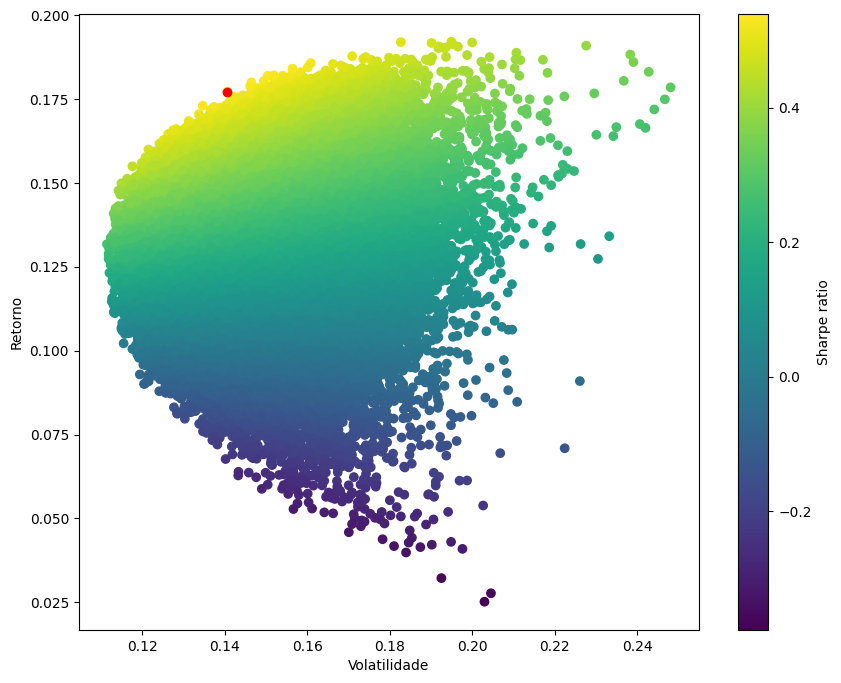

In [74]:
# Gráfico de dispersão
plt.figure(figsize=(10,8))
plt.scatter(dados_M["lista_volatilidade_esperada"], dados_M['lista_retorno_esperado'], c = dados_M['lista_sharpe_ratio'])
plt.colorbar(label = 'Sharpe ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.scatter(melhor_volatilidade, melhor_retorno, c = 'red');

# 2.3 Método Hill Climb

In [75]:
df = pd.read_csv('carteira.csv')

In [76]:
# Função para maximizar Shape ration
def fitness_function(pesos):
  df = pd.read_csv('carteira.csv')
  capital = 100

  for i in df.columns[1:]:
    df[i] = (df[i] / df[i][0])

  for i, k in enumerate(df.columns[1:]):
    df[k] = df[k] * pesos[i] * capital

  df.drop(labels = ['Date'], axis = 1, inplace=True)
  df['Capital'] = df.sum(axis = 1)
  df['tx retorno'] = 0.0

  for i in range(1, len(df)):
    df['tx retorno'][i] = ((df['Capital'][i] / df['Capital'][i - 1]) - 1) * 100

  sharpe_ratio = (df['tx retorno'].mean() - media_cdi) / df['tx retorno'].std() * np.sqrt(246)

  return sharpe_ratio

In [77]:
# Função para otimizar portfólio 
def Hill_climb():
    np.random.seed(10)
    pesos = np.random.random(len(df.columns) - 1)
    pesos = pesos / pesos.sum()
    fitness_function(pesos)
    fitness = mlrose.CustomFitness(fitness_function)
    maximizacao = mlrose.ContinuousOpt(length=len(teste.columns)-1, fitness_fn=fitness, maximize = True, min_val = 0, max_val = 1)
    pesos_HC, Sharpe_HC = mlrose.hill_climb(maximizacao, random_state = 1)
    pesos_HC = pesos_HC / pesos_HC.sum()
    return pesos_HC,Sharpe_HC

In [78]:
# Utilizando o método Hill Climb
pesos_HC,sharpe_HC= Hill_climb()

In [79]:
# Devido esse código demorar muito, torna interessante salvar os resultados
dados_HC = {
    "pesos_HC": pesos_HC,
    "sharpe_HC": sharpe_HC,
}

In [80]:
with open('dados_alocacao_hill_climb.pkl', 'wb') as f:
    pickle.dump(dados_HC, f)

In [81]:
with open('dados_alocacao_hill_climb.pkl', 'rb') as f:
    dados_HC = pickle.load(f)

In [82]:
# Criando uma carteira para Hill Climb
df_HC, _, _, soma_valor = alocacao_ativos(pd.read_csv('carteira.csv'), 100000, melhores_pesos=dados_HC['pesos_HC'])
df_HC.to_csv('df_HC.csv') # Devido a demora de processamento é útil salvar os resultados

In [83]:
df_HC = pd.read_csv('df_hc.csv')

## 2.4 Método Simulated_annealing

In [84]:
# Função para otimizar portfólio 
def Simulated_annealing():
   np.random.seed(10)
   pesos = np.random.random(len(df.columns) - 1)
   pesos = pesos / pesos.sum()
   fitness_function(pesos)
   fitness = mlrose.CustomFitness(fitness_function)
   maximizacao = mlrose.ContinuousOpt(length=len(teste.columns)-1, fitness_fn=fitness, maximize = True, min_val = 0, max_val = 1)
   pesos_SA, Sharpe_SA = mlrose.simulated_annealing(maximizacao, random_state = 1)
   pesos_SA = pesos_SA/ pesos_SA.sum()
   return pesos_SA,Sharpe_SA


In [85]:
# Utilizando o método Simulated Annealing
pesos_SA,sharpe_SA= Simulated_annealing()

In [86]:
# Devido esse código demorar muito, torna interessante salvar os resultados
dados_SA = {
    "pesos_SA": pesos_SA,
    "shape_SA": sharpe_SA,
}

In [87]:
with open('dados_alocacao_simulated_annealing.pkl', 'wb') as f:
    pickle.dump(dados_SA, f)

In [88]:
with open('dados_alocacao_simulated_annealing.pkl', 'rb') as f:
    dados_SA = pickle.load(f)

In [89]:
# Observando o resultado
df_SA, _, _, _ = alocacao_ativos(pd.read_csv('carteira.csv'), 100000, melhores_pesos=dados_SA['pesos_SA'])
df_SA.to_csv('df_SA.csv')

In [90]:
df_SA=pd.read_csv('df_SA.csv')

# 3 Comparativo dos resultados

### 3.1 Rentabilidade

In [91]:
# Buscando os dados do Bova 11
df_bov = pd.DataFrame()
df_bov['BOVA11']= yf.download('BOVA11.SA', start='2021-01-01',end='2024-06-04')['Adj Close']
df_bov.to_csv('bova11.csv')

[*********************100%%**********************]  1 of 1 completed


In [92]:
# Criando DF com valores do BOVA11 para comparar a carteira com o índice IBOVESPA
df_bov = pd.read_csv('bova11.csv')
df_bov['tx retorno'] = ((df_bov['BOVA11'] / df_bov['BOVA11'].shift(1)) - 1) * 100
df_bov.dropna()

,Date,BOVA11,tx retorno
1,2021-01-05,114.690002,0.525906
2,2021-01-06,114.550003,-0.122068
3,2021-01-07,118.370003,3.334788
4,2021-01-08,120.400002,1.714960
5,2021-01-11,118.620003,-1.478404
...,...,...,...
845,2024-05-27,120.870003,0.190653
846,2024-05-28,120.180000,-0.570863
847,2024-05-29,119.120003,-0.882008
848,2024-05-31,118.660004,-0.386164


In [93]:
# Comparando as taxas de retornos simples
tx_anual_M = df_M['tx retorno'].mean() * 246
tx_anual_HC = df_HC['tx retorno'].mean() * 246
tx_anual_SA = df_SA['tx retorno'].mean() * 246
tx_anual_bov = df_bov['tx retorno'].mean() * 246

print(f'A taxa de retorno simples da carteira de Markowitz é {tx_anual_M:.2f}%')
print(f'A taxa de retorno simples da carteira de Hill Climb é {tx_anual_HC:.2f}%')
print(f'A taxa de retorno simples da carteira de Simulated Annealing é {tx_anual_SA:.2f}%')
print(f'A taxa de retorno simples da carteira de BOVA11 é {tx_anual_bov:.2f}%')

A taxa de retorno simples da carteira de Markowitz é 18.77%
A taxa de retorno simples da carteira de Hill Climb é 27.72%
A taxa de retorno simples da carteira de Simulated Annealing é 27.72%
A taxa de retorno simples da carteira de BOVA11 é 3.00%


In [94]:
visualiza_carteira(pesos_markoitz)
visualiza_carteira(pesos_HC)
visualiza_carteira(pesos_SA)

TAEE11.SA tem 12.67% da carteira
BBAS3.SA tem 18.52% da carteira
ABEV3.SA tem 0.31% da carteira
WEGE3.SA tem 0.15% da carteira
RANI3.SA tem 17.71% da carteira
GOGL34.SA tem 19.86% da carteira
BERK34.SA tem 30.77% da carteira
TAEE11.SA tem 0.00% da carteira
BBAS3.SA tem 0.00% da carteira
ABEV3.SA tem 0.00% da carteira
WEGE3.SA tem 0.00% da carteira
RANI3.SA tem 100.00% da carteira
GOGL34.SA tem 0.00% da carteira
BERK34.SA tem 0.00% da carteira
TAEE11.SA tem 0.00% da carteira
BBAS3.SA tem 0.00% da carteira
ABEV3.SA tem 0.00% da carteira
WEGE3.SA tem 0.00% da carteira
RANI3.SA tem 100.00% da carteira
GOGL34.SA tem 0.00% da carteira
BERK34.SA tem 0.00% da carteira


In [95]:
# Criando um portfólio com somente BOVA11 para comparação
peso_bov = np.array([1])
df_bov = pd.read_csv('bova11.csv')
df_bov,_,_,_ = alocacao_ativos(df=df_bov,capital=100000,melhores_pesos=peso_bov)

In [96]:
# Criando DF para comparação de rentabilidade
df_carteira = pd.DataFrame()
df_carteira['Carteira Markowitz'] = df_M['Capital']
df_carteira['Carteira Hill Climb'] = df_HC['Capital']
df_carteira['Carteira Simulated Annealing'] = df_SA['Capital']
df_carteira['Carteira IBOVESPA'] = df_bov['Capital']
df_carteira.dropna()

,Carteira Markowitz,Carteira Hill Climb,Carteira Simulated Annealing,Carteira IBOVESPA
0,100000.000000,100000.000000,100000.000000,100000.000000
1,99392.094940,98886.840573,98886.840573,100525.905971
2,100433.452398,98330.254988,98330.254988,100403.196361
3,104237.204465,106679.073984,106679.073984,103751.430052
4,105532.693564,110389.632806,110389.632806,105530.726085
...,...,...,...,...
845,184967.411241,213003.071692,213003.071692,105942.682642
846,182606.349154,210786.874389,210786.874389,105337.894787
847,183652.846334,211771.858796,211771.858796,104408.805829
848,183999.733140,208816.882092,208816.882092,104005.616155


In [97]:
# Normalizando as carteira para melhor comparação das rentabilidade
df_carteira_normalizado = df_carteira.copy()
for i in df_carteira_normalizado.columns[0:]:
  df_carteira_normalizado[i] = df_carteira_normalizado[i] / df_carteira_normalizado[i][0]

df_carteira_normalizado.dropna()

,Carteira Markowitz,Carteira Hill Climb,Carteira Simulated Annealing,Carteira IBOVESPA
0,1.000000,1.000000,1.000000,1.000000
1,0.993921,0.988868,0.988868,1.005259
2,1.004335,0.983303,0.983303,1.004032
3,1.042372,1.066791,1.066791,1.037514
4,1.055327,1.103896,1.103896,1.055307
...,...,...,...,...
845,1.849674,2.130031,2.130031,1.059427
846,1.826063,2.107869,2.107869,1.053379
847,1.836528,2.117719,2.117719,1.044088
848,1.839997,2.088169,2.088169,1.040056


In [98]:
# Criando gráfico das cotações
figura = px.line(title = 'Comparação da rentabilidade das carteiras')

for i, coluna in enumerate(df_carteira_normalizado.columns):
    figura.add_scatter(x=df_carteira_normalizado.index, y=df_carteira_normalizado[coluna], name=coluna, line=dict(color=cores[i]))


figura.update_layout(
    
    title_x=0.5
)

figura.show()

### 3.2 Riscos

In [99]:
df_carteira_normalizado.dropna()
for col in df_carteira_normalizado.columns:
    coef_variacao = (df_carteira_normalizado[col].std() / df_carteira_normalizado[col].mean()) * 100
    print(f'O coeficiente de variação da {col} é {coef_variacao:.2f}%')


O coeficiente de variação da Carteira Markowitz é 15.19%
O coeficiente de variação da Carteira Hill Climb é 27.36%
O coeficiente de variação da Carteira Simulated Annealing é 27.36%
O coeficiente de variação da Carteira IBOVESPA é 7.61%
